In [2]:
%matplotlib notebook

import time  # slow the game down a little bit
from pyglet.window import key  # for manual playing

import gym
import numpy as np  # used for all kinds of matrix / vector operations
import matplotlib.pyplot as plt  # for plotting

c:\users\ayomi\anaconda3\envs\my_rl_env\lib\site-packages\ale_py\roms\utils.py:90: DeprecationWarning: SelectableGroups dict interface is deprecated. Use select.
  for external in metadata.entry_points().get(self.group, []):
c:\users\ayomi\anaconda3\envs\my_rl_env\lib\site-packages\ale_py\roms\__init__.py:94: DeprecationWarning: Automatic importing of atari-py roms won't be supported in future releases of ale-py. Please migrate over to using `ale-import-roms` OR an ALE-supported ROM package. To make this warning disappear you can run `ale-import-roms --import-from-pkg atari_py.atari_roms`.For more information see: https://github.com/mgbellemare/Arcade-Learning-Environment#rom-management
  _RESOLVED_ROMS = _resolve_roms()


In [3]:
env = gym.make("CartPole-v1")  # We want to solve the CartPole task
env.reset()  # Reset to initial state
for _ in range(100):
    env.render()  # Render on the screen
    action = env.action_space.sample()  # chose a random action
    observation, reward, done, info = env.step(action)
    #time.sleep(0.02)
env.close()  # dont forget to close the environment

c:\users\ayomi\anaconda3\envs\my_rl_env\lib\site-packages\gym\envs\classic_control\cartpole.py:151: UserWarning: WARN: You are calling 'step()' even though this environment has already returned done = True. You should always call 'reset()' once you receive 'done = True' -- any further steps are undefined behavior.
  "You are calling 'step()' even though this "


In [4]:
observation

array([ 2.2468715,  1.7667019, -9.9914875, -9.44437  ], dtype=float32)

In [5]:
def create_bins(num_bins_per_obs=10):
    #-4.8 to 4.8
    bins_cart_position = np.linspace(-4.8, 4.8, num_bins_per_obs)
    #-infinity to infinity
    # We gotta play to find reasonable values
    bins_cart_velocity = np.linspace(-5, 5, num_bins_per_obs)
    #Radians for pole angle deg (-24 deg, 24 deg)
    bins_pole_angle = np.linspace(-0.418, 0.418, num_bins_per_obs)
    # -infinity to infinity
    # Select reasonable values based on personal playing experience
    bins_pole_angular_velocity = np.linspace(-5,5,num_bins_per_obs)
    
    bins = np.array([bins_cart_position, 
                    bins_cart_velocity,
                    bins_pole_angle,
                    bins_pole_angular_velocity])

    return bins

In [6]:
NUM_BINS = 10
BINS = create_bins(NUM_BINS)

In [7]:
# BINS

In [8]:
# Map from continous to discrete
# np.digitize()

In [9]:
demo_bin = [0, 2, 4, 6, 8, 10]

In [10]:
demo_data = 9.143589

In [11]:
np.digitize(demo_data, demo_bin)

5

In [12]:
def discretize_observation(observations, bins):
    
    binned_observations = []
    
    for i, observation in enumerate(observations):
        discr_observation = np.digitize(observation, bins[i])
        
        binned_observations.append(discr_observation)
    
    # Tuple important for indexing
    return tuple(binned_observations)

In [13]:
observations = env.reset()

In [14]:
observations

array([-0.03022804, -0.00950431,  0.02751421,  0.03882669], dtype=float32)

In [15]:
mapped_observation = discretize_observation(observations, BINS)

In [16]:
mapped_observation

(5, 5, 5, 5)

In [17]:
q_table_shape = (NUM_BINS, NUM_BINS, NUM_BINS, NUM_BINS, env.action_space.n)

In [18]:
q_table = np.zeros(q_table_shape)

In [19]:
# q_table
q_table.shape

(10, 10, 10, 10, 2)

In [20]:
def epsilon_greedy_action_selection(epsilon, q_table, discrete_state):
    '''
    Returns an action for the agent. Note how it uses a random number to decide on
    exploration versus explotation trade-off.
    '''
    random_number = np.random.random()
    
    # EXPLOITATION, USE BEST Q(s,a) Value
    if random_number > epsilon:
        # Action row for a particular state
        #state_row = q_table[discrete_state,:]
        # Index of highest action for state
        # Recall action is mapped to index (e.g. 0=LEFT, 1=DOWN, etc..)
        #action = np.argmax(state_row)
        action = np.argmax(q_table[discrete_state])
    
    # EXPLORATION, USE A RANDOM ACTION
    else:
        # Return a random 0,1,2,3 action
        #action = env.action_space.sample()
        action = np.random.randint(0, env.action_space.n)
        
    return action

In [21]:
def compute_next_q_value(old_q_value, reward, next_optimal_q_value):
    
    return old_q_value +  ALPHA * (reward + GAMMA * next_optimal_q_value - old_q_value)


In [ ]:
EPOCHS = 20000
ALPHA = 0.8
GAMMA = 0.9

In [ ]:
epsilon = 1.0

#minimum amount of epsilon needed to start reducing
BURN_IN = 1

#hard stop for epsilon reduction
EPSILON_END = 10000

#amount epsilon is reduced by, affects training speed
EPSILON_REDUCE = 0.0001

In [ ]:
def reduce_episolon(epsilon, epoch):
    
    #check current epoch
    if BURN_IN <= epoch <= EPSILON_END:
        epsilon -= EPSILON_REDUCE
        
    return epsilon

In [ ]:
def fail(done, points, reward):
    if done and points < 150:
        reward = -200
    
    ## Can add anything, ex.
    ## ANGULAR VELOCITY +/-
    
    return reward

<IPython.core.display.Javascript object>


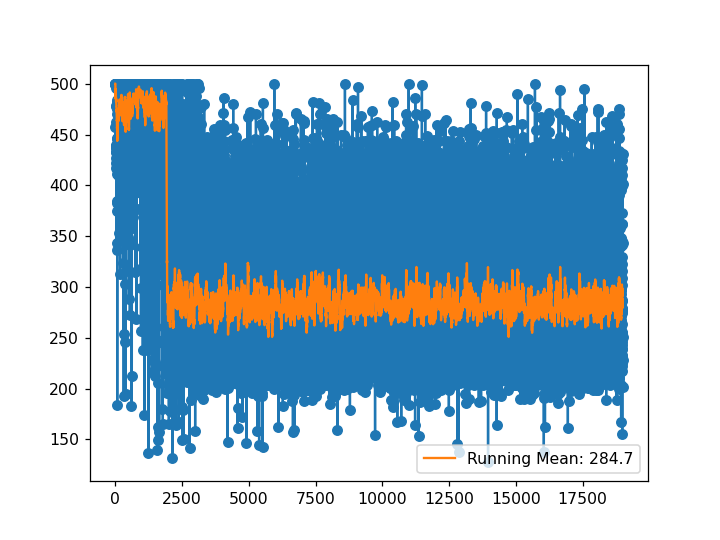

In [28]:
###### VISUALIZATION #######

#How often to plot progress
log_interval = 1000

#How often to show the game
render_interval = 10000

fig = plt.figure()
ax= fig.add_subplot(111)
plt.ion()
fig.canvas.draw()

#######################

points_log = []
mean_points_log = []
epochs = []

#######################

for epoch in range(EPOCHS):
    
    initial_state = env.reset()
    discretized_state = discretize_observation(initial_state, BINS)
    
    done = False
    points = 0
    
    epochs.append(epoch)
    
    
    # PLAY GAME
    while not done:
        
        action = epsilon_greedy_action_selection(epsilon, q_table, discretized_state)
        next_state, reward, done, info = env.step(action)
        
        reward = fail(done, points, reward)
        
        next_state_discretized = discretize_observation(next_state, BINS)
        
        old_q_value = q_table[discretized_state + (action,)]
        next_optimal_q_value = np.max(q_table[next_state_discretized])
        next_q = compute_next_q_value(old_q_value, reward, next_optimal_q_value)
        q_table[discretized_state + (action,)] = next_q
        
        discretized_state = next_state_discretized
        points += 1
        
    epsilon = reduce_episolon(epsilon, epoch)
    points_log.append(points)
    running_mean = round(np.mean(points_log[-30:]), 2)
    mean_points_log.append(running_mean)
    
    ####################################
    if epoch % log_interval == 0:
        ax.clear()
        ax.scatter(epochs, points_log)
        ax.plot(epochs, points_log)
        ax.plot(epochs, mean_points_log, label=f'Running Mean: {running_mean}')
        plt.legend()
        fig.canvas.draw()
        
env.close()

In [29]:
observation = env.reset()
rewards = 0

for step in range(1000):
    env.render()
    discretized_state = discretize_observation(observation, BINS)
    action = np.argmax(q_table[discretized_state])
    time.sleep(0.01)
    observation, reward, done, info = env.step(action)
    rewards += 1
    
    if done:
        print(f"You got {rewards} points!")
        break

You got 392 points!
